<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание данных

**Технологический процесс**

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    * Xanthate — ксантогенат (промотер, или активатор флотации);
    * Sulphate — сульфат (на данном производстве сульфид натрия);
    * Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

Наименование признаков
Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]

Возможные значения для блока [этап]:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока [тип_параметра]

* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики


In [1]:
pip install catboost

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from numpy.random import RandomState
from sklearn.model_selection import GridSearchCV

In [3]:
pth1 = 'gold_industry_train.csv'
pth2 = '/datasets/gold_industry_train.csv'

if os.path.exists(pth1):
    train = pd.read_csv(pth1)
elif os.path.exists(pth2):
    train = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
pth1 = 'gold_industry_test.csv'
pth2 = '/datasets/gold_industry_test.csv'

if os.path.exists(pth1):
    test = pd.read_csv(pth1)
elif os.path.exists(pth2):
    test = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [5]:
pth1 = 'gold_industry_full.csv'
pth2 = '/datasets/gold_industry_full.csv'

if os.path.exists(pth1):
    full = pd.read_csv(pth1)
elif os.path.exists(pth2):
    full = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [6]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


В рамках подготовки данных нам необходимо проверить формулу вычисления эффективности обогащения. Формула выглядит так:

`recovery = ((C * (F - T)) / (F * (C - T))) * 100%`

где:

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Основываясь на полученных от компании данных, необходимые нам признаки для проверки формулы это:

* rougher.output.concentrate_au (С)
* rougher.input.feed_au (F)
* rougher.output.tail_au (T)

А сам результат работы формулы находится здесь:

* rougher.output.recovery

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery.

Найдем MAE между нашими расчётами и значением признака.

Создадим новый столбец с результатом вычисления эффективности обогащения по формуле.

## Подготовка данных

Избавимся от пропусков в столбце rougher.output.recovery

In [7]:
train.dropna(subset = ['rougher.output.recovery'], inplace = True)

In [8]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

In [9]:
calculation = ((C * (F - T)) / (F * (C - T))) * 100

Построим гистограмму для сравнения рассчетов

<Axes: >

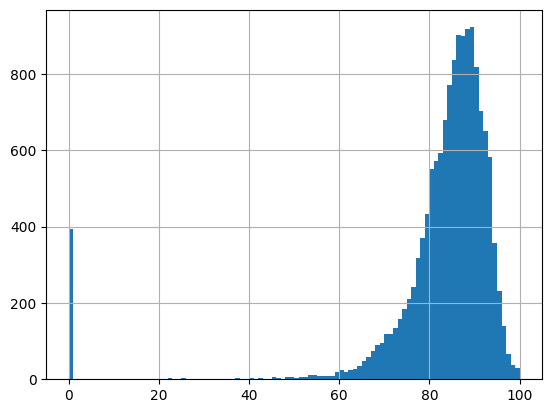

In [10]:
calculation.hist(bins=100)

<Axes: >

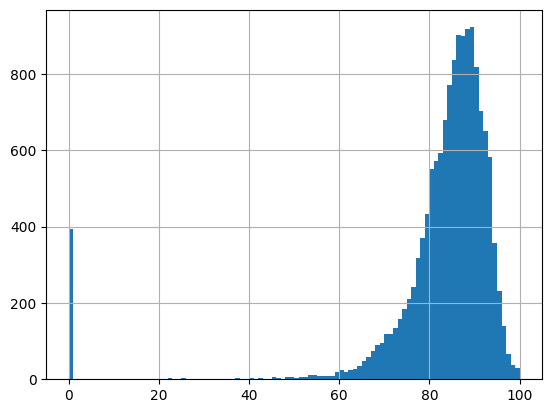

In [11]:
train['rougher.output.recovery'].hist(bins=100)

In [12]:
calculation.head(10)

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
5    88.156912
6    88.168065
7    87.668336
8    87.035862
9    88.280699
dtype: float64

In [13]:
train['rougher.output.recovery'].head(10)

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
5    88.156912
6    88.168065
7    87.668336
8    87.035862
9    88.280699
Name: rougher.output.recovery, dtype: float64

Графики и первые 10 строчек идентичные, что говорить о том что рассчеты верны.

Произведем рассчеты MAE

In [14]:
print('MAE', mean_absolute_error(calculation, train['rougher.output.recovery']))

MAE 9.83758577644259e-15


Среднее обсалютное отклонеие очень мало, данные действительно почти не различаются, рассчеты верны.

Сравним выборки test и train.

In [15]:
print(train.shape)
print(test.shape)

(14579, 87)
(4860, 53)


В обучающей выборке больше признаков чем в тестовой, изучим недостающие признаки.

In [16]:
missing_column = train.columns.drop(test.columns)
print(missing_column)
print('\nКоличество отсутствующих признаков -', len(missing_column))

Index(['rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.recovery',
       'rougher.output.tail_au', 'rougher.output.tail_ag',
       'rougher.output.tail_pb', 'rougher.output.tail_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_ag',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'secondary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_ag',
       'secondary_cleaner.output.tail_pb', 'secondary_cleaner.ou

По сути это целевые признаки. Это концентрация различных веществ на выходе после отчистки, а также доля веществ в отвальных хвостах.

Получается что у нас есть 53 признака ( те что в test) и нам нужны 2 целевых признака `rougher.output.recovery, final.output.recovery`

Далее уберем целевые признаки из обучающей выборки и добавим их в тестовую.

In [17]:
col_missing_column = missing_column.drop(['rougher.output.recovery', 'final.output.recovery'])
right_cols = train.columns.drop(col_missing_column)
train = train[right_cols]

Тепер подготовим тестовую выборку. Будем использовать столбец `date` как индекс.

In [18]:
target_to_join = full[['date', 'final.output.recovery', 'rougher.output.recovery']].copy()

In [19]:
test = test.join(target_to_join.set_index('date'), on='date')

Проверим на пропуски в целевых признаках.

In [20]:
test['final.output.recovery'].isna().value_counts()

False    4860
Name: final.output.recovery, dtype: int64

In [21]:
train['final.output.recovery'].isna().value_counts()

False    14579
Name: final.output.recovery, dtype: int64

In [22]:
train['rougher.output.recovery'].isna().value_counts()

False    14579
Name: rougher.output.recovery, dtype: int64

In [23]:
test['rougher.output.recovery'].isna().value_counts()

False    4860
Name: rougher.output.recovery, dtype: int64

Пропуски в целевых признаках отсутсвуют.

In [24]:
test.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [25]:
print(test.shape)
print(train.shape)

(4860, 55)
(14579, 55)


**Вывод**
* Избавились от пропусков в столбце rougher.output.recovery
* Проверили правильность расчета эффективности обогащения. МАЕ равно предельно малому значению.
* Сравнили выборки test и train.
* В тестовую выборку были добавлены целевые признаки `rougher.output.recovery, final.output.recovery`, которые будут необходимы в дальнейшем для рассчета итоговой метрики качества.

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

**Золото**

In [26]:
au_data = (full[[
    'rougher.input.feed_au',
    'rougher.output.concentrate_au',
    'primary_cleaner.output.concentrate_au',
    'final.output.concentrate_au']].copy())

**Серебро**

In [27]:
ag_data = (full[[
    'rougher.input.feed_ag',
    'rougher.output.concentrate_ag',
    'primary_cleaner.output.concentrate_ag',
    'final.output.concentrate_ag']].copy())

**Cвинeц**

In [28]:
pb_data = (full[[
    'rougher.input.feed_pb',
    'rougher.output.concentrate_pb',
    'primary_cleaner.output.concentrate_pb',
    'final.output.concentrate_pb']].copy())

Напишем функцию которая будет строить графики всех четырех столбцов на одном графике

In [29]:
def draw_graph(data, title):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_ylabel('Кол-во наблюдений')
    ax.set_xlabel('Концентрация металла')
    ax.set_title(title)
    for col in data:
        data[col].hist(alpha=.3)
        ax.legend(['Исходное сырье','Флотация','Первичная очистка', 'Вторичная очистка'])

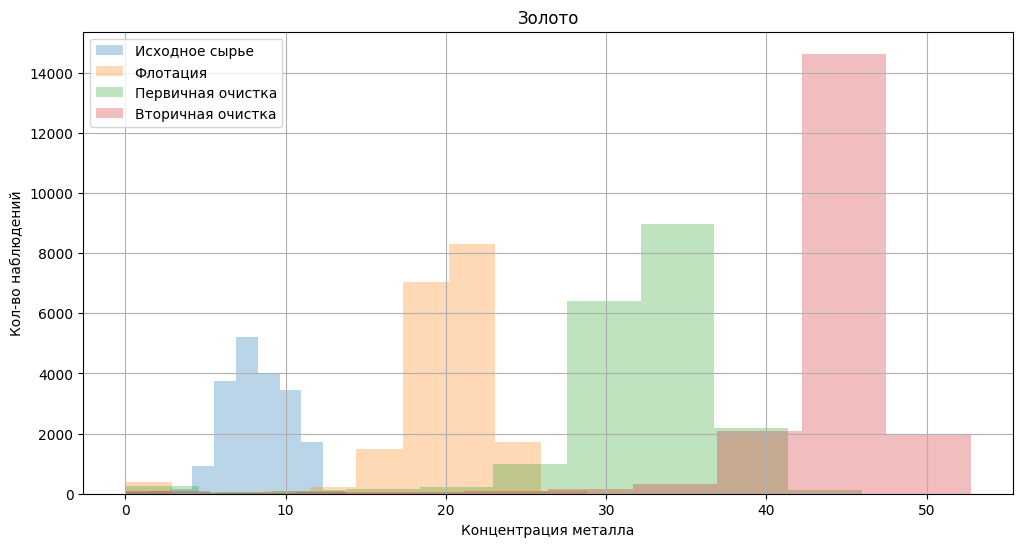

In [30]:
draw_graph(au_data, 'Золото')

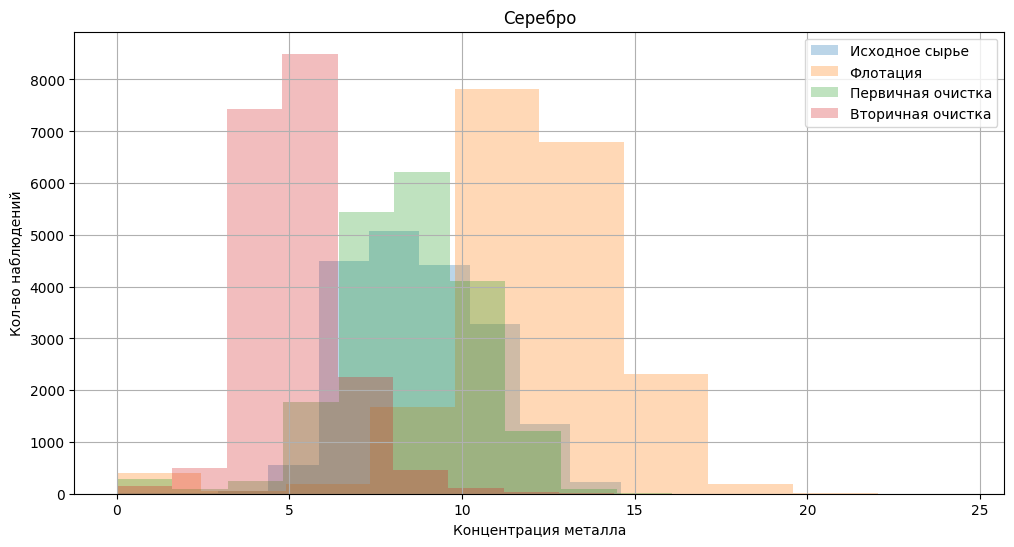

In [31]:
draw_graph(ag_data, 'Серебро')

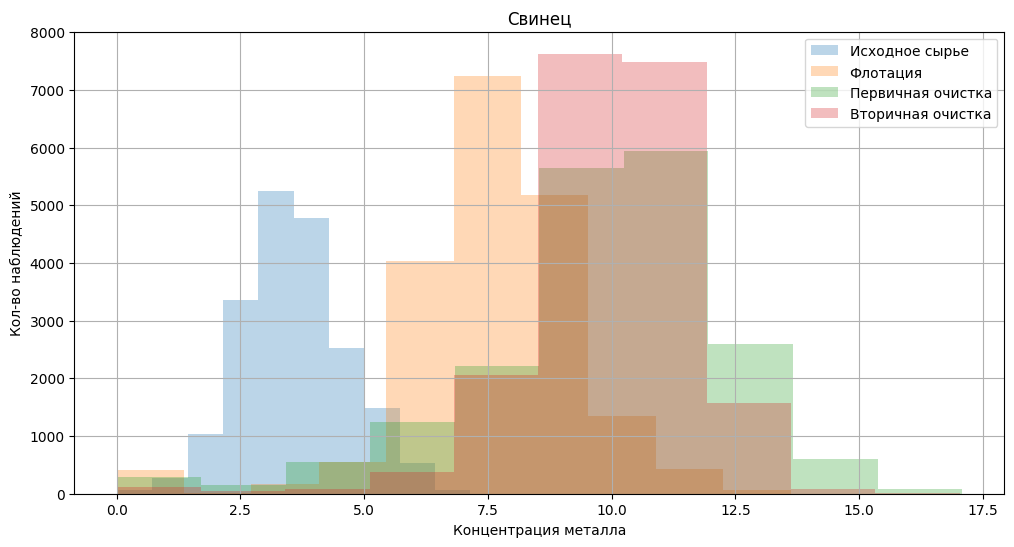

In [32]:
draw_graph(pb_data, 'Свинец')

На графиках становиться видно что содержания металла разное на различных этапах, так например видно как с каждым новым этапом ростёт содержание золота, серебра становитсья меньше после вторичной очистки, а для свинца концентрация после первичной и вторичной очиски практически одинаковое

В датасете есть 2 параметра `feed_size` это `rougher.input.feed_size` и `primary_cleaner.input.feed_size` сравним их распределения в обучающей и тестовой выборках.

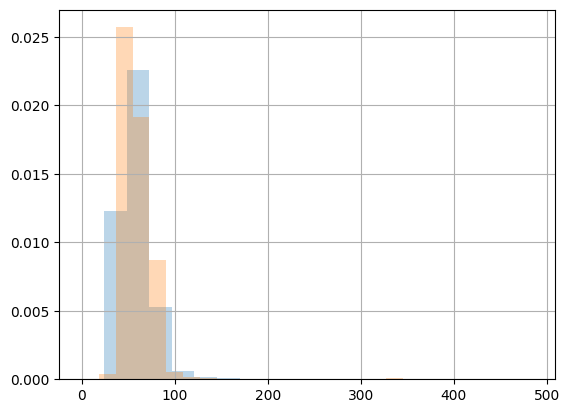

In [33]:
train['rougher.input.feed_size'].hist(bins=20,density=True, alpha=.3)
test['rougher.input.feed_size'].hist(bins=20,density=True, alpha=.3)
plt.show()

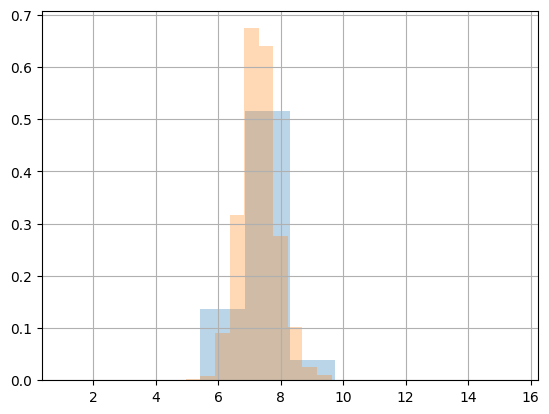

In [34]:
train['primary_cleaner.input.feed_size'].hist(density=True, alpha=.3)
test['primary_cleaner.input.feed_size'].hist(density=True, alpha=.3)
plt.show()

У обоих параметров не сильно различатся параметры, эти различия не должны сильно повлиять на модель.

Cоздадим новый датасет с данныим о концентрации веществ и просуммируем их концентрацию на разных стадиях

In [35]:
concentrate_data = full[[
    'date','rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol',
    'rougher.input.feed_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
    'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag',
    'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']].copy()

concentrate_data['conc_sum_rougher'] = concentrate_data[
    'rougher.input.feed_ag'] + concentrate_data['rougher.input.feed_pb'] + concentrate_data[
    'rougher.input.feed_sol'] + concentrate_data['rougher.input.feed_au']

concentrate_data['conc_sum_primary'] = concentrate_data[
    'primary_cleaner.output.concentrate_ag'] + concentrate_data['primary_cleaner.output.concentrate_pb'] + concentrate_data[
    'primary_cleaner.output.concentrate_sol'] + concentrate_data['primary_cleaner.output.concentrate_au']

concentrate_data['conc_sum_final'] = concentrate_data[
    'final.output.concentrate_ag'] + concentrate_data['final.output.concentrate_pb'] + concentrate_data[
    'final.output.concentrate_sol'] + concentrate_data['final.output.concentrate_au']


Построим гистограммы для суммарных концентраций веществ

<Axes: >

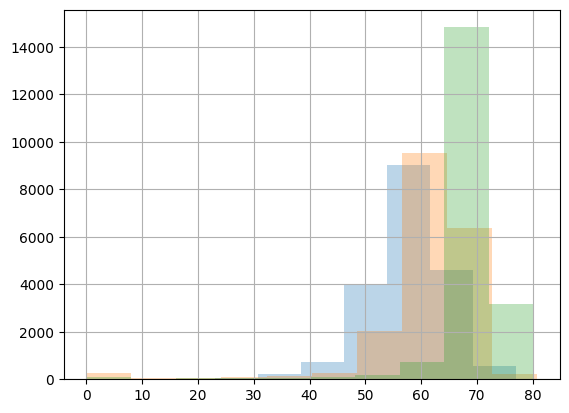

In [36]:
concentrate_data['conc_sum_rougher'].hist(alpha=.3)
concentrate_data['conc_sum_primary'].hist(alpha=.3)
concentrate_data['conc_sum_final'].hist(alpha=.3)

По графикам видим, что в суммарных данных присутсвуют нулевые или близких к нулю значений. Нужно избавиться от наблюдений с такими аномалиями, чтобы они не повлияли на качество модели.

Создадим датасет с аномальными наблюдениями

In [37]:
anomaly = (concentrate_data[['date', 'conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
           .copy()
           .query('conc_sum_rougher == 0 or conc_sum_primary == 0 or conc_sum_final == 0')
           .fillna(0))

In [38]:
anomaly.sample(10)

,date,conc_sum_rougher,conc_sum_primary,conc_sum_final
11123,2017-07-07 02:59:59,68.352122,0.000000,71.263933
9244,2017-04-05 05:59:59,0.000000,0.000000,64.690452
25,2016-01-16 01:00:00,57.764677,0.000000,63.765751
9249,2017-04-05 10:59:59,0.000000,0.000000,64.690452
11898,2017-08-10 08:59:59,66.538045,0.000000,70.374035
10325,2017-06-02 01:59:59,51.940241,0.000000,0.000000
11110,2017-07-06 13:59:59,65.819140,0.000000,72.999385
9377,2017-04-11 00:59:59,55.061367,0.000000,70.788415
10881,2017-06-26 21:59:59,66.157124,68.515189,0.000000
516,2016-02-08 00:00:00,46.703740,53.725613,0.000000


Избавимся от аномальных значений в обучающей выборке.

In [39]:
train = train.join(anomaly.set_index('date'), on='date')

In [40]:
train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = train[[
    'conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']].fillna(-1)

In [41]:
train = train.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')

Проверим, что все выполнилось правильно - значением всех признаков должно быть -1

<Axes: >

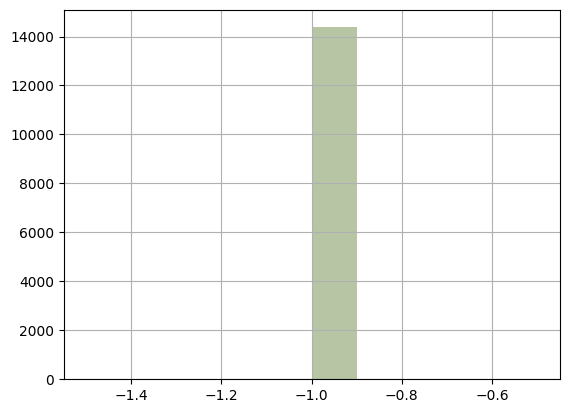

In [42]:
train['conc_sum_rougher'].hist(alpha=.2)
train['conc_sum_primary'].hist(alpha=.2)
train['conc_sum_final'].hist(alpha=.2)

Избавимся от ненужных столбцов

In [43]:
train.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis='columns', inplace=True)

In [44]:
train.dropna(inplace=True)

In [45]:
print(train.shape)
print(test.shape)

(13225, 55)
(4860, 55)


Все готово, можно построить модель.

**Вывод**
* Доля золота увеличивается по мере прохождения этапов очистки
* Распределения гранул сырья на обучающей и тестовой выборках значительных различий не имеют
* Анамалии были удалены для улучшения качества будущих моделей прогнозирования

## Модель

Создадим функцию для рассчета метрики качества модели - sMAPE (Symmetric Mean Absolute Percentage Error).

In [46]:
def smape (target, predictions):
    return 100/len(target) * np.sum(2 * np.abs(predictions - target) / (np.abs(target) + np.abs(predictions)))

In [47]:
smape_scorer = make_scorer(smape, greater_is_better = False)

А также функцию для рассчета итогового sMAPE

In [48]:
def final_smape (rougher, final):
    return 0.25 * rougher + 0.75 * final

Подготовим features и target для обучающей выборки.

In [49]:
target_rougher = train['rougher.output.recovery']
target_final = train['final.output.recovery']

features_train = train.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis='columns')

Проверим несколько моделей методом кросс-валидации и выберем лучший результат.

In [50]:
state=RandomState(777)

**DecisionTreeRegressor**

In [51]:
model_dtr = DecisionTreeRegressor(random_state=state)
cross_val_score(model_dtr, features_train, target_rougher, cv=3).mean()

-1.5868668409352071

In [52]:
best_result_for_dtr = 100
best_param_for_dtr = 0
for n in range(1, 10, 1):
    model_dtr_rougher = DecisionTreeRegressor(max_depth=n, random_state=state)
    smape_rougher = cross_val_score(model_dtr_rougher,
                              features_train,
                              target_rougher,
                              scoring=smape_scorer,
                              cv=3)
    final_smape_rougher = smape_rougher.mean()

    model_dtr_final = DecisionTreeRegressor(max_depth=n, random_state=state)
    smape_final = cross_val_score(model_dtr_final,
                                  features_train,
                                  target_final,
                                  scoring=smape_scorer,
                                  cv=3)
    final_smape_final = smape_final.mean()
    result_smape = final_smape(final_smape_rougher, final_smape_final)*(-1)
    if result_smape < best_result_for_dtr:
        best_result_for_dtr = result_smape
        best_param_for_dtr = n
dct_with_scores= best_result_for_dtr
print(dct_with_scores)

10.248319437326375


**LinearRegression**

In [53]:
model_lr = LinearRegression()
cross_val_score(model_lr, features_train, target_rougher, cv=3).mean()

-0.33268518756823956

In [54]:
model_lr_rougher = LinearRegression()
smape_rougher = cross_val_score(model_lr_rougher,
                          features_train,
                          target_rougher,
                          scoring=smape_scorer,
                          cv=3)
final_smape_rougher = smape_rougher.mean()
model_lr_final = LinearRegression()
smape_final = cross_val_score(model_lr_final,
                        features_train,
                        target_final,
                        scoring=smape_scorer,
                        cv=3)
final_smape_final = smape_final.mean()
result_smape = final_smape(final_smape_rougher, final_smape_final)*(-1)
dct_with_scores = result_smape
print(dct_with_scores)

11.166135453160907


**CatBoostRegressor**

In [55]:
model_cb = CatBoostRegressor(iterations=2, learning_rate=1, depth=2)
cross_val_score(model_cb, features_train, target_rougher, cv=3).mean()

0:	learn: 12.5225610	total: 57.2ms	remaining: 57.2ms
1:	learn: 12.1346109	total: 65.1ms	remaining: 0us
0:	learn: 12.7483610	total: 9.22ms	remaining: 9.22ms
1:	learn: 12.2280527	total: 16.9ms	remaining: 0us
0:	learn: 13.2281343	total: 8.07ms	remaining: 8.07ms
1:	learn: 12.2756298	total: 16.8ms	remaining: 0us


-0.3297013348362244

In [56]:
cbr = CatBoostRegressor()

In [57]:
parametrs = { 'iterations': range (1, 5, 1),
              'depth': range (1,10, 1) }


In [58]:
grid = GridSearchCV(cbr, parametrs, cv=3)
grid.fit(features_train, target_rougher)

Learning rate set to 0.5
0:	learn: 13.6911548	total: 8.26ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 13.3608974	total: 3.36ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 14.4473040	total: 3.07ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 13.6911548	total: 6.69ms	remaining: 6.69ms
1:	learn: 13.1526233	total: 12.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 13.3608974	total: 6.8ms	remaining: 6.8ms
1:	learn: 12.9692869	total: 10.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 14.4473040	total: 4.44ms	remaining: 4.44ms
1:	learn: 14.0578297	total: 9.31ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 13.6911548	total: 4.14ms	remaining: 8.29ms
1:	learn: 13.1526233	total: 8.69ms	remaining: 4.34ms
2:	learn: 12.9289427	total: 10.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 13.3608974	total: 6.48ms	remaining: 13ms
1:	learn: 12.9692869	total: 10.1ms	remaining: 5.06ms
2:	learn: 12.7489992	total: 13.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f840ca11570>,
             param_grid={'depth': range(1, 10), 'iterations': range(1, 5)})

In [59]:
grid.best_params_

{'depth': 6, 'iterations': 4}

In [60]:
grid = GridSearchCV(cbr, parametrs, cv=3)
grid.fit(features_train, target_final)

Learning rate set to 0.5
0:	learn: 7.7217494	total: 2.23ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.7974671	total: 2.16ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.7827825	total: 2.08ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.7217494	total: 2.09ms	remaining: 2.09ms
1:	learn: 7.4597081	total: 4.58ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.7974671	total: 2.03ms	remaining: 2.03ms
1:	learn: 7.5595328	total: 3.96ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.7827825	total: 2.11ms	remaining: 2.11ms
1:	learn: 7.4783928	total: 4.12ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.7217494	total: 2.13ms	remaining: 4.27ms
1:	learn: 7.4597081	total: 4.86ms	remaining: 2.43ms
2:	learn: 7.2893806	total: 7.31ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.7974671	total: 2.11ms	remaining: 4.23ms
1:	learn: 7.5595328	total: 4.16ms	remaining: 2.08ms
2:	learn: 7.3656070	total: 6.41ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.7827825

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f840ca11570>,
             param_grid={'depth': range(1, 10), 'iterations': range(1, 5)})

In [61]:
grid.best_params_

{'depth': 2, 'iterations': 4}

In [62]:
model_cbr_rougher = CatBoostRegressor(iterations=4, depth=6)
smape_rougher = cross_val_score(model_cbr_rougher,
                                  features_train,
                                  target_rougher,
                                  scoring=smape_scorer,
                                  cv=3)
final_smape_rougher = smape_rougher.mean()

model_rfr_final = CatBoostRegressor(iterations=4, depth=2)
smape_final = cross_val_score(model_rfr_final,
                                features_train,
                                target_final,
                                scoring=smape_scorer,
                                cv=3)
final_smape_final = smape_final.mean()
result_smape = final_smape(final_smape_rougher, final_smape_final)*(-1)

print(result_smape)

Learning rate set to 0.5
0:	learn: 12.1503556	total: 14.6ms	remaining: 43.8ms
1:	learn: 11.3700668	total: 29.8ms	remaining: 29.8ms
2:	learn: 10.6059491	total: 44.3ms	remaining: 14.8ms
3:	learn: 10.3845859	total: 62.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 11.5189565	total: 14.5ms	remaining: 43.6ms
1:	learn: 10.6306191	total: 31ms	remaining: 31ms
2:	learn: 9.9375999	total: 45.2ms	remaining: 15.1ms
3:	learn: 9.6287781	total: 64.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 12.5900650	total: 17.7ms	remaining: 53.2ms
1:	learn: 11.1321903	total: 32.5ms	remaining: 32.5ms
2:	learn: 10.5070845	total: 47.1ms	remaining: 15.7ms
3:	learn: 10.1891939	total: 61.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.5132519	total: 3.65ms	remaining: 11ms
1:	learn: 7.2103889	total: 6.88ms	remaining: 6.88ms
2:	learn: 7.0468739	total: 10ms	remaining: 3.33ms
3:	learn: 6.9367179	total: 13.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.6029949	total: 6.27ms	remaining: 18.8ms
1

**RandomForestRegressor**

In [63]:
for i in range(5,10,1):
    model_rf = RandomForestRegressor(random_state=777, n_estimators=i)
    print(cross_val_score(model_rf, features_train, target_rougher, cv=3).mean())

-1.639699939340573
-1.3842110969230903
-1.1211642673973718
-1.0051110323391645
-0.903832004247


In [64]:
rfr = RandomForestRegressor()

In [65]:
param_grid = [{'n_estimators': [3, 10, 30],
               'max_features': [2, 4, 6, 8],
               'max_depth': [1, 3, 5, 7, 9, 11],
               'random_state': [state]},
              {'bootstrap': [False],
               'n_estimators': [3, 10],
               'max_features': [2, 3, 4],
               'max_depth': [1, 3, 5, 7, 9, 11],
               'random_state': [state]},
]

In [66]:
grid = GridSearchCV(rfr, param_grid, cv=3)
grid.fit(features_train, target_rougher)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [1, 3, 5, 7, 9, 11],
                          'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30],
                          'random_state': [RandomState(MT19937) at 0x7F840CEB9240]},
                         {'bootstrap': [False],
                          'max_depth': [1, 3, 5, 7, 9, 11],
                          'max_features': [2, 3, 4], 'n_estimators': [3, 10],
                          'random_state': [RandomState(MT19937) at 0x7F840CEB9240]}])

In [67]:
grid.best_params_

{'bootstrap': False,
 'max_depth': 5,
 'max_features': 3,
 'n_estimators': 10,
 'random_state': RandomState(MT19937) at 0x7F840CEB9240}

In [68]:
grid = GridSearchCV(rfr, param_grid, cv=3)
grid.fit(features_train, target_final)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [1, 3, 5, 7, 9, 11],
                          'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30],
                          'random_state': [RandomState(MT19937) at 0x7F840CEB9240]},
                         {'bootstrap': [False],
                          'max_depth': [1, 3, 5, 7, 9, 11],
                          'max_features': [2, 3, 4], 'n_estimators': [3, 10],
                          'random_state': [RandomState(MT19937) at 0x7F840CEB9240]}])

In [69]:
grid.best_params_

{'max_depth': 3,
 'max_features': 8,
 'n_estimators': 10,
 'random_state': RandomState(MT19937) at 0x7F840CEB9240}

In [70]:
model_rfr_rougher = RandomForestRegressor(max_depth= 5, max_features= 3, n_estimators= 10, random_state=state)
smape_rougher = cross_val_score(model_rfr_rougher,
                                  features_train,
                                  target_rougher,
                                  scoring=smape_scorer,
                                  cv=3)
final_smape_rougher = smape_rougher.mean()

model_rfr_final = RandomForestRegressor(max_depth= 3, max_features= 8, n_estimators= 10, random_state=state)
smape_final = cross_val_score(model_rfr_final,
                                features_train,
                                target_final,
                                scoring=smape_scorer,
                                cv=3)
final_smape_final = smape_final.mean()
result_smape = final_smape(final_smape_rougher, final_smape_final)*(-1)

print(result_smape)

9.720033904237185


Лучший результат показывает модель CatBoost. Обучим её.

Подготовим features и target для тестовой выборки и масштабируем признаки.

In [71]:
target_rougher_test = test['rougher.output.recovery']
target_final_test = test['final.output.recovery']

features_test = test.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis='columns')

Обучим модель и получим предсказания.

In [72]:
model_cb = CatBoostRegressor(iterations=4, depth=6)
model_cb_1 = CatBoostRegressor(iterations=4, depth=2)

cb_rougher = model_cb.fit(features_train, target_rougher)
cb_final = model_cb_1.fit(features_train, target_final)

cb_predictions_rougher = cb_rougher.predict(features_test)
cb_predictions_final = cb_final.predict(features_test)

Learning rate set to 0.5
0:	learn: 12.4610294	total: 16.8ms	remaining: 50.5ms
1:	learn: 11.4129278	total: 32.8ms	remaining: 32.8ms
2:	learn: 10.8329860	total: 48.8ms	remaining: 16.3ms
3:	learn: 10.5088478	total: 64ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 7.7029573	total: 4.08ms	remaining: 12.2ms
1:	learn: 7.3286029	total: 7.68ms	remaining: 7.68ms
2:	learn: 7.1317916	total: 11.4ms	remaining: 3.79ms
3:	learn: 7.0266071	total: 14.9ms	remaining: 0us


Посчитаем sMAPE для обоих признаков и итоговый

In [73]:
smape_rougher = smape(target_rougher_test, cb_predictions_rougher)

In [74]:
smape_final = smape(target_final_test, cb_predictions_final)

In [75]:
final_smape(smape_rougher, smape_final)

7.386702171870651

Проверим качество модели, сравнив с константной. Для этого будем использовать модель DummyRegressor.

In [76]:
dummy = DummyRegressor(strategy = 'mean')
dummy_1 = DummyRegressor(strategy = 'mean')

dummy_rougher = dummy.fit(features_train, target_rougher)
dummy_predictions_rougher = dummy_rougher.predict(features_test)

dummy_final = dummy_1.fit(features_train, target_final)
dummy_predictions_final = dummy_final.predict(features_test)

In [77]:
smape_rougher_dummy = smape(target_rougher_test, dummy_predictions_rougher)

In [78]:
smape_final_dummy = smape(target_final_test, dummy_predictions_final)

In [79]:
final_smape(smape_rougher_dummy, smape_final_dummy)

8.667836982352153

Обученная модель предсказывает результат точнее константной. Это говорит о том, что построенная модель адекватна.

**Вывод:**
* Написали функции для рассчета sMAPE и итогового sMAPE.
* Проверили несколько формул кросс-валидацией.
* Проверили работу модели на тестовой выборке с помощью метрики качества sMAPE и сравнения с константной моделью.
* Подготовили прототип модели машинного обучения для «Цифры»